# Pre-Process Assembled Dataset

Notes: - Includes data from 1st March 2020 - 31st March 2021

In [1]:
# Importing Libraries
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from datetime import timedelta
from collections import Counter

import NI_M1
import NI_M2
reload(NI_M1)
reload(NI_M2)


importing Jupyter notebook from NI_M1.ipynb
importing Jupyter notebook from NI_M2.ipynb
importing Jupyter notebook from NI_M1.ipynb
importing Jupyter notebook from NI_M2.ipynb


<module 'NI_M2' from 'NI_M2.ipynb'>

## Import and check assembled dataset

In [2]:

ReadCSV = True

if ReadCSV:
    df_Assembled = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Assembled.csv')

print('Size of dataset:', df_Assembled.shape)
                               

C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Size of dataset: (374244, 85)


In [142]:

df_All = df_Assembled

# Visualise NI idendified using M1
Filter_M1 = df_All['NC_Method1'] == 1
df_M1 = df_All[Filter_M1]
df_M1['diagnosis_group'].head(5)


4      N179~N189~I500~U071~Y95X~J128~B972~J181~Y95X~J...
96     U072~J189~Y95X~J439~I489~Z867~N183~Z966~I517~Z...
109    S0690~W199~U071~Y95X~Z290~R296~Z960~-1~-1~-1~-...
127    U071~Y95X~J128~B972~Y95X~J9690~B972~Y95X~Z290~...
134    K222~U071~Y95X~T812~A490~I639~I652~T827~B957~K...
Name: diagnosis_group, dtype: object

In [143]:

# Visualise NI idendified using M2_15
Filter_M2_15 = df_All['NC_Method2_15'] == 1
df_M2_15 = df_All[Filter_M2_15]
if any( df_M2_15['Diff_EPIstart_Admission'] < 15 ):
    print('There are issues with Method 2.15')
else:
    print('No issue with Method 2.15')
    
# Visualise NI idendified using M2_8
Filter_M2_8 = df_All['NC_Method2_8'] == 1
df_M2_8 = df_All[Filter_M2_8]
if any( df_M2_15['Diff_EPIstart_Admission'] < 8 ):
    print('There are issues with Method 2.15')
else:
    print('No issue with Method 2.8')

df_All.head(2)


No issue with Method 2.15
No issue with Method 2.8


,Unnamed: 0,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,period,procedure_group,...,livercoded,HIV,Charlson_Score,Obesity,Diff_EPIstart_Admission,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods
0,0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,FY2020-21,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,...,1,0,1,0,45,0,1,1,0,1
1,1,2169012,9.97,8.0,4.0,British,White,7.007830e+11,FY2020-21,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,...,0,0,1,1,0,0,0,0,0,0


## Convert dates into relative time-deltas

In [144]:

df = df_All

# Initial drop of columns
ColumnDrops = ['Unnamed: 0', 'Fiscal_Month', 'FinY', 'period']
if 'DatePeriod' in ColumnDrops:
    ColumnDrops.append('DatePeriod')
    
df = df.drop(columns=ColumnDrops)

# # Convert Dates to numerical time deltas
# DateList = ['Admission_date', 'Discharge_date']

# for dateColumn in DateList:
#     DateOrigin = min(pd.to_datetime(df[dateColumn], format='%d/%m/%Y'))
#     Date_Format = pd.to_datetime(df[dateColumn], format='%d/%m/%Y')
#     df[dateColumn+'_Delta'] = (Date_Format-DateOrigin).dt.days
#     print('Reference for', dateColumn, ':', DateOrigin)

df['Discharge_date'] = pd.to_datetime(df['Discharge_date'], format='%d/%m/%Y').dt.strftime('%d/%m/%Y')
df['Admission_date'] = pd.to_datetime(df['Admission_date'], format='%d/%m/%Y').dt.strftime('%d/%m/%Y')

df.head(2)


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,livercoded,HIV,Charlson_Score,Obesity,Diff_EPIstart_Admission,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,1,0,1,0,45,0,1,1,0,1
1,2169012,9.97,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0,0,1,1,0,0,0,0,0,0


## Modelling strain on trust on day of admission

In [145]:

# Open dataset with hospital activity
OpenExcel = False
if OpenExcel:
    df_HospitalActivity = pd.read_excel(r'O:\GIRFT DiRAC\FlavienHardy\0_Datasets_Ini\07.20\All hospital activity 19-07-21.xlsx')

ColumnList = ['Admission_date', 'ProvCode', 'Count COVID only', 'non-COVID only']
df_HospitalActivity_Sub = df_HospitalActivity[ColumnList]
df_HospitalActivity_Sub.head(2)


,Admission_date,ProvCode,Count COVID only,non-COVID only
0,2019-05-01,AAH,0,4
1,2019-05-01,ACG,0,81


In [146]:

def HospitalActivitySameDay(df_ini, df_HospitalActivity_Sub):
    df = df_ini

    # Convert admission dates features as date_time
    df_HospitalActivity_Sub['Admission_date'] = pd.to_datetime(df_HospitalActivity_Sub['Admission_date'], format='%Y-%m-%d')
    df['Admission_date'] = pd.to_datetime(df['Admission_date'], format='%d/%m/%Y')

    # Merge Covid and non-Covid activity
    ColumnList = ['Admission_date', 'ProvCode']
    df_Merged = pd.merge(df, df_HospitalActivity_Sub, how='left', on=ColumnList)
    df_Merged = df_Merged.rename(columns={'Count COVID only':'CountSameDay_Covid', 'non-COVID only':'CountSameDay_NonCovid'})

    # Filling in NaNs
    Features = ['CountSameDay_Covid', 'CountSameDay_NonCovid']
    for feature in Features:
        df_Merged[feature] = df_Merged[feature].fillna(0)
        df_Merged[feature] = df_Merged[feature].astype('int')

    # Create feature for specific wave according to admission date
    FirstWave_end = pd.to_datetime('31/07/2020', format='%d/%m/%Y')
    df_Merged['Admission_date'] = pd.to_datetime(df_Merged['Admission_date'], format='%Y-%m-%d')
    Filter = df_Merged['Admission_date']<=FirstWave_end
    df_Merged['Wave'] = np.where(Filter, 1, 2)

    # Find maximum number of admissions during specific wave
    ColumnList = ['Provider_Name', 'Wave', 'Admission_date', 'CountSameDay_Covid', 'CountSameDay_NonCovid']
    df_WaveMaxPatients_Covid = df_Merged[ColumnList].groupby(by=['Provider_Name', 'Wave'])['CountSameDay_Covid'].max().to_frame(name='MaxWave_Covid').reset_index()
    df_WaveMaxPatients_NonCovid = df_Merged[ColumnList].groupby(by=['Provider_Name', 'Wave'])['CountSameDay_NonCovid'].max().to_frame(name='MaxWave_NonCovid').reset_index()

    ColumnList = ['Provider_Name', 'Wave']
    df_Merged = pd.merge(df_Merged, df_WaveMaxPatients_Covid, how='left', on=ColumnList)
    df_Merged = pd.merge(df_Merged, df_WaveMaxPatients_NonCovid, how='left', on=ColumnList)

    # Add proportion to maximum admissions during specific wave
    df_Merged['PropMaxPatientsWave_Covid'] = 100*df_Merged['CountSameDay_Covid']/df_Merged['MaxWave_Covid']
    df_Merged['PropMaxPatientsWave_NonCovid'] = 100*df_Merged['CountSameDay_NonCovid']/df_Merged['MaxWave_NonCovid']

    # Drop intermediary features
    ColumnDrop = ['Wave', 'MaxWave_Covid', 'MaxWave_NonCovid']
    df_Merged = df_Merged.drop(columns=ColumnDrop)
    
    return df_Merged

df4 = HospitalActivitySameDay(df, df_HospitalActivity_Sub)
df4.head(10)


<ipython-input-146-6a17f1276ec6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HospitalActivity_Sub['Admission_date'] = pd.to_datetime(df_HospitalActivity_Sub['Admission_date'], format='%Y-%m-%d')


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,Diff_EPIstart_Admission,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,CountSameDay_Covid,CountSameDay_NonCovid,PropMaxPatientsWave_Covid,PropMaxPatientsWave_NonCovid
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,45,0,1,1,0,1,39,167,57.352941,53.184713
1,2169012,9.970,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0,0,0,0,0,0,0,444,0.000000,82.835821
2,2201273,2.314,10.0,5.0,British,White,7.007760e+11,W461~Z943~U212~Y982~Z924~Z401~U051~Y981~-1~-1~...,Male,90,...,0,0,0,0,0,0,14,191,63.636364,68.953069
3,2947750,11.831,7.0,4.0,British,White,7.007770e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,39,...,0,0,0,0,0,0,3,302,7.500000,91.515152
4,3445944,30.350,3.0,2.0,British,White,7.007880e+11,U212~Y981~Z411~Z941~Z413~Z941~Z421~X403~X404~X...,Male,52,...,11,1,0,1,0,1,24,558,34.782609,77.932961
5,3882797,10.623,8.0,4.0,British,White,7.007770e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Male,55,...,0,0,0,0,0,0,1,216,5.000000,80.000000
6,3917891,24.126,4.0,2.0,British,White,7.007770e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Male,86,...,0,0,0,0,0,0,1,207,1.960784,57.660167
7,4672517,4.961,10.0,5.0,British,White,7.007830e+11,U201~Y981~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~...,Female,78,...,0,0,0,0,0,0,3,229,5.769231,42.723881
8,4941705,25.301,4.0,2.0,Irish,White,7.007910e+11,U136~Y981~Z856~Z942~-1~-1~-1~-1~-1~-1~-1~-1~-1...,Male,77,...,0,0,0,0,0,0,6,961,4.195804,77.876823
9,5020090,8.226,9.0,5.0,British,White,7.007780e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,49,...,0,0,0,0,0,0,3,277,8.823529,75.890411


## Identifying ICD-10 codes more common in NI

In [147]:

# Importing ICD-10 codes used throughout each spell
ReadCSV = True
if ReadCSV:
    df_ICD10 = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\Data\1_Processed\FH_ICD10_AllEpisodes.csv')

print('Number of spells:', df_ICD10.shape)
df_ICD10.head(2)


Number of spells: (486304, 3)


,Unnamed: 0,P_Spell_ID,ICD10_All
0,0,1656,J189-J128-B972-J9690-U072
1,1,2864,G710-J128-B972-L984-I489-U071-F059-R268-J9690-...


In [148]:

#  Merge back on current dataset

def MergeICD10_AllEpisodes(df_ini):
    df = df_ini
    ColumnList = ['P_Spell_ID', 'ICD10_All']
    df_ICD10_Sub = df_ICD10[ColumnList]

    df = pd.merge(df4, df_ICD10_Sub, how='left', on='P_Spell_ID')
    df = df.drop(columns=['diagnosis_group'])
    
    return df

df5 = MergeICD10_AllEpisodes(df4)
df5.head(2)


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,CountSameDay_Covid,CountSameDay_NonCovid,PropMaxPatientsWave_Covid,PropMaxPatientsWave_NonCovid,ICD10_All
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,0,1,1,0,1,39,167,57.352941,53.184713,B968-Z921-T814-I517-F112-M7265-Z867-U071-Z870-...
1,2169012,9.97,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0,0,0,0,0,0,444,0.000000,82.835821,Z950-K590-I10X-E119-E669-G473-Z861-I489-U071-Z...


In [249]:

# Dictionaries of ICD-10 disease severity codes
d_Pneumonia = {}
d_Pneumonia['Pneumonia'] = ['J12', 'J15', 'J168', 'J17', 'J18']
d_Pneumonia['Aspiration Pneumonia'] = ['J690', 'J698']
d_Pneumonia['Respiratory Failure (Acute and Unspecified)'] = ['J960', 'J969']
d_Pneumonia['Pulmonary Embolism'] = ['I26']
d_Pneumonia['Adult Respiratory Distress Syndrom (ARDS)'] = ['J80']
d_Pneumonia['Pulmonary Fibrosis'] = ['J841(.*?)B972']
d_Pneumonia['Acute Upper Respiratory Conditions'] = ['J00', 'J040', 'J042', 'J069']

d_Kidney = {}
d_Kidney['Renal Failure (Acute)'] = ['N17']

d_BloodClotting = {}
d_BloodClotting['Thrombocytopaenia'] = ['D695', 'D696', 'D688', 'D689']
d_BloodClotting['DIC Syndrome'] = ['D65']
d_BloodClotting['Venous Sinus Thrombosis'] = ['G08', 'G951']
d_BloodClotting['Other Blood Clotting'] = ['I74', 'I80', 'I81', 'I82']

d_CardiologyCirculation = {}
d_CardiologyCirculation['Myocarditis'] = ['I40', 'I411', 'I514', 'I520', 'I521']
d_CardiologyCirculation['Acute MI'] = ['I21', 'I22']
d_CardiologyCirculation['Cardiomyopathy'] = ['I430']
d_CardiologyCirculation['Vasculitis'] = ['I776']

d_Neurology = {}
d_Neurology['Stroke (Due to Covid-10)'] = ['I60', 'I61', 'I62', 'I63', 'I64']
d_Neurology['Brain Injury'] = ['A858', 'A86', 'G048', 'G049', 'G931']

d_DigestiveSystem = {}
d_DigestiveSystem['Intestinal Ischaemia'] = ['K550']

d_Sepsis = {}
d_Sepsis['Sepsis'] = ['R572', 'A40', 'A41']

# Lists of ICD-10 disease severity codes
def DictToList(d):
    List = []
    for item in d.values():
        List += item
    Pattern = '|'.join(List)
    return Pattern

Severity = {}
Severity['Pneumonia'] = DictToList(d_Pneumonia)
Severity['Kidney'] = DictToList(d_Kidney)
Severity['BloodClotting'] = DictToList(d_BloodClotting)
Severity['CardiologyCirculation'] = DictToList(d_CardiologyCirculation)
Severity['Neurology'] = DictToList(d_Neurology)
Severity['DigestiveSystem'] = DictToList(d_DigestiveSystem)
Severity['Sepsis'] = DictToList(d_Sepsis)
Severity


{'Pneumonia': 'J12|J15|J168|J17|J18|J690|J698|J960|J969|I26|J80|J841(.*?)B972|J00|J040|J042|J069',
 'Kidney': 'N17',
 'BloodClotting': 'D695|D696|D688|D689|D65|G08|G951|I74|I80|I81|I82',
 'CardiologyCirculation': 'I40|I411|I514|I520|I521|I21|I22|I430|I776',
 'Neurology': 'I60|I61|I62|I63|I64|A858|A86|G048|G049|G931',
 'DigestiveSystem': 'K550',
 'Sepsis': 'R572|A40|A41'}

In [253]:

# Find occurence of severity codes

def SeverityCodes(df_ini):
    df = df_ini
    for disease in list(Severity.keys()):
        Occurence = df['ICD10_All'].str.contains(Severity[disease], regex=True)
        df['Severity_'+disease] = np.where(Occurence, 1, 0)
    return df

df6 = SeverityCodes(df5)

df6.head(2)


C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,PropMaxPatientsWave_Covid,PropMaxPatientsWave_NonCovid,ICD10_All,Severity_Pneumonia,Severity_Kidney,Severity_BloodClotting,Severity_CardiologyCirculation,Severity_Neurology,Severity_DigestiveSystem,Severity_Sepsis
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,57.352941,53.184713,B968-Z921-T814-I517-F112-M7265-Z867-U071-Z870-...,0,0,1,0,0,0,0
1,2169012,9.97,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0.000000,82.835821,Z950-K590-I10X-E119-E669-G473-Z861-I489-U071-Z...,0,0,0,0,0,0,0


## Drop columns

In [254]:

# df6 = df5

# df6['Discharge_date'] = pd.to_datetime(df6['Discharge_date'], format='%d/%m/%Y').dt.strftime('%d/%m/%Y')
# df6['Admission_date'] = pd.to_datetime(df6['Admission_date'], format='%d/%m/%Y').dt.strftime('%d/%m/%Y')

# Drop date columns, keep time-deltas
# ColumnList = ['Admission_date', 'Discharge_date', 'EPIstart', 'EPIend']
ColumnList = ['EPIstart', 'EPIend']
df6 = df6.drop(columns=ColumnList)
df6.shape

# Drop Spell-ID and HESID
# ColumnList = ['P_Spell_ID', 'HESID']
ColumnList = ['HESID']
df6 = df6.drop(columns=ColumnList)
df6.shape


(374244, 89)

In [255]:

# Dropping obvious columns

df7 = df6

ColumnList_1 = ['Ethnicity_updated']
ColumnList_2 = ['IMD_decile', 'IMD_quintile']
ColumnList_3 = ['Epikey', 'ageband', 'Consult']
ColumnList_4 = ['ProvCode', 'Provider_Name', 'Sitecode'] # Keeping LSOA_2011_Code for IMD scores
ColumnList_5 = ['main_specialty_code', 'epiorder'] # Unsure
ColumnList_6 = ['ICD10_All', 'Fiscal_Month_name'] 
ColumnList_7 = ['Read30', 'Read90', 'Read30spellid', 'Read90spellid'] 
ColumnList_8 = ['discharge_method_code_Spell', 'Discharge_to_death'] # dis_dest_desc_Spell is a categorical description of Discharge_destination_spell
ColumnList_9 = ['ONSMort_RECORD_ID', 'ONSMort_DOD', 'ONSMort_CAUSE_OF_DEATH']
ColumnList_10 = ['HFRS_Score'] # Keep HFRS band instead, following Keith's advice
ColumnList_11 = ['Discharge_destination_spell'] # Categorical description of discharge_method_code_Spell
ColumnList = ColumnList_1 + ColumnList_2 + ColumnList_3 + ColumnList_4 + ColumnList_5 + ColumnList_6 + ColumnList_7 + ColumnList_8 + ColumnList_9 + ColumnList_10 + ColumnList_11

df7 = df7.drop(columns=ColumnList)
print('Number of features left: ', df7.shape[1])
print('Features remaining:', df7.columns)


Number of features left:  65
Features remaining: Index(['P_Spell_ID', 'IMD_score', 'ethnicity_updated_cat', 'procedure_group',
       'sex', 'age_of_patient', 'region', 'LSOA_2011_Code', 'POD',
       'SpellCCdays', 'MORT', 'Discharge_Method_Description_Spell',
       'Spell_Los', 'Admission_date', 'Discharge_date', 'dis_dest_desc_Spell',
       'inhospital_MORT_ONS', 'Hopper_Index_1', 'Hopper_Index_2',
       'Hopper_Index_3', 'Hopper_Index_4', 'Hopper_Index_5', 'Hopper_Index_6',
       'Hopper_Index_7', 'Total_Hopper_Domains', 'HFRS_Band', 'Periferal_vasc',
       'heart_fail', 'Acute_MI', 'cerebral_vasc', 'dementia', 'Pulmonary_dis',
       'Connective', 'Peptic_ulcer', 'Liver_dis', 'Diabetes_without',
       'Diabetes_with', 'diabetescoded', 'Hemi_para', 'Renal_dis', 'cancer',
       'metastatic', 'cancercoded', 'Severe_liver', 'livercoded', 'HIV',
       'Charlson_Score', 'Obesity', 'Diff_EPIstart_Admission', 'NC_Method1',
       'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_

## Deal with categorical variables

### Link with IMD components

In [256]:

# Importing File
ReadExcel = True
if ReadExcel:
    df_IMD = pd.read_excel(r'O:\GIRFT DiRAC\FlavienHardy\0_Datasets_Ini\06.28\File_2_ID_2015_Domains_of_deprivation.xlsx', sheet_name='ID2015 Domains')

df_IMD.head(2)


,LSOA code (2011),LSOA name (2011),Local Authority District code (2013),Local Authority District name (2013),Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),Employment Rank (where 1 is most deprived),Employment Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Rank (where 1 is most deprived)","Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Health Deprivation and Disability Rank (where 1 is most deprived),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01031349,Adur 001A,E07000223,Adur,21352,7,18992,6,19305,6,13727,5,25876,8,12817,4,28166,9,18367,6
1,E01031350,Adur 001B,E07000223,Adur,8864,3,9233,3,7879,3,6969,3,6883,3,12781,4,11399,4,16242,5


In [257]:

df_3_2 = df7

# Including IMD RANKS, following Jonathan's advice
ColumnList = ['LSOA code (2011)',
              'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
              'Income Rank (where 1 is most deprived)',
              'Employment Rank (where 1 is most deprived)',
              'Education, Skills and Training Rank (where 1 is most deprived)',
              'Health Deprivation and Disability Rank (where 1 is most deprived)',
              'Crime Rank (where 1 is most deprived)',
              'Barriers to Housing and Services Rank (where 1 is most deprived)',
              'Living Environment Rank (where 1 is most deprived)']

df_IMD_sub = df_IMD[ColumnList]
df_3_2 = pd.merge(df_3_2, df_IMD_sub, how='left', left_on='LSOA_2011_Code', right_on='LSOA code (2011)').drop(columns=['LSOA_2011_Code', 'LSOA code (2011)'])

# Renaming IMD components
Dict = {'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)':'IMD_Rank',
        'Income Rank (where 1 is most deprived)':'IMD_Income Rank',
        'Employment Rank (where 1 is most deprived)':'IMD_Employment Rank',
        'Education, Skills and Training Rank (where 1 is most deprived)':'IMD_Education, Skills and Training Rank',
        'Health Deprivation and Disability Rank (where 1 is most deprived)':'IMD_Health Deprivation and Disability Rank',
        'Crime Rank (where 1 is most deprived)':'IMD_Crime Rank',
        'Barriers to Housing and Services Rank (where 1 is most deprived)':'IMD_Barriers to Housing and Services Rank',
        'Living Environment Rank (where 1 is most deprived)':'IMD_Living Environment Rank'}
df_3_2 = df_3_2.rename(columns=Dict)

print('New size:', df_3_2.shape)
df_3_2.head(2)


New size: (374244, 72)


,P_Spell_ID,IMD_score,ethnicity_updated_cat,procedure_group,sex,age_of_patient,region,POD,SpellCCdays,MORT,...,Severity_DigestiveSystem,Severity_Sepsis,IMD_Rank,IMD_Income Rank,IMD_Employment Rank,"IMD_Education, Skills and Training Rank",IMD_Health Deprivation and Disability Rank,IMD_Crime Rank,IMD_Barriers to Housing and Services Rank,IMD_Living Environment Rank
0,1487000,NaN,White,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,Midlands,EM,0.0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2169012,9.97,White,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,South East,EM,0.0,0,...,0,0,24268.0,21832.0,24592.0,18148.0,20241.0,24211.0,19908.0,16613.0


### Verify feature dtypes

In [263]:

df_4 = df_3_2

Series_dtypes = df_4.dtypes

# Change object type features into category types
for feature in list(df_4.columns):
    if Series_dtypes[feature]=='object':
        df_4[feature] = df_4[feature].astype('category')

# Print feature dtypes
Print = True
if Print:
    for feature in list(df_4.columns):
        print(feature, '->', Series_dtypes[feature])


P_Spell_ID -> int64
IMD_score -> int32
ethnicity_updated_cat -> category
procedure_group -> category
sex -> category
age_of_patient -> int64
region -> category
POD -> category
SpellCCdays -> float64
MORT -> int64
Discharge_Method_Description_Spell -> category
Spell_Los -> int64
Admission_date -> datetime64[ns]
Discharge_date -> category
dis_dest_desc_Spell -> category
inhospital_MORT_ONS -> int64
Hopper_Index_1 -> int64
Hopper_Index_2 -> int64
Hopper_Index_3 -> int64
Hopper_Index_4 -> int64
Hopper_Index_5 -> int64
Hopper_Index_6 -> int64
Hopper_Index_7 -> int64
Total_Hopper_Domains -> int64
HFRS_Band -> category
Periferal_vasc -> int64
heart_fail -> int64
Acute_MI -> int64
cerebral_vasc -> int64
dementia -> int64
Pulmonary_dis -> int64
Connective -> int64
Peptic_ulcer -> int64
Liver_dis -> int64
Diabetes_without -> int64
Diabetes_with -> int64
diabetescoded -> int64
Hemi_para -> int64
Renal_dis -> int64
cancer -> int64
metastatic -> int64
cancercoded -> int64
Severe_liver -> int64
live

### Missing values

In [268]:

Print = True
if Print:
    for feature in list(df_4.columns):
        if any(df_4[feature].isnull()):
            print(feature, '->', df_4[feature].isnull().sum(), 'NaNs')
            print('Filling missing values...')
            if feature.startswith('IMD_'):
                ModeVal = df_4[feature].dropna().mode()[0]
                df_4[feature].fillna(ModeVal, inplace=True)
            elif Series_dtypes[feature] in ['float64']:
                ModeVal = df_4[feature].dropna().mean()
                df_4[feature].fillna(ModeVal, inplace=True)
            elif Series_dtypes[feature] in ['category', 'int32']:
                ModeVal = df_4[feature].dropna().mode()[0]
                df_4[feature].fillna(ModeVal, inplace=True)
                
if not(df_4.isnull().any().any()):
    print('No missing value left.')

df_4.shape



No missing value left.


(374244, 72)

In [269]:

# Change object type features from IMD_ features
for feature in list(df_4.columns):
    if feature.startswith('IMD_'):    
        df_4[feature] = df_4[feature].astype('int32')

Series_dtypes = df_4.dtypes

# Print feature dtypes
Print = True
if Print:
    for feature in list(df_4.columns):
        print(feature, '->', Series_dtypes[feature])


P_Spell_ID -> int64
IMD_score -> int32
ethnicity_updated_cat -> category
procedure_group -> category
sex -> category
age_of_patient -> int64
region -> category
POD -> category
SpellCCdays -> float64
MORT -> int64
Discharge_Method_Description_Spell -> category
Spell_Los -> int64
Admission_date -> datetime64[ns]
Discharge_date -> category
dis_dest_desc_Spell -> category
inhospital_MORT_ONS -> int64
Hopper_Index_1 -> int64
Hopper_Index_2 -> int64
Hopper_Index_3 -> int64
Hopper_Index_4 -> int64
Hopper_Index_5 -> int64
Hopper_Index_6 -> int64
Hopper_Index_7 -> int64
Total_Hopper_Domains -> int64
HFRS_Band -> category
Periferal_vasc -> int64
heart_fail -> int64
Acute_MI -> int64
cerebral_vasc -> int64
dementia -> int64
Pulmonary_dis -> int64
Connective -> int64
Peptic_ulcer -> int64
Liver_dis -> int64
Diabetes_without -> int64
Diabetes_with -> int64
diabetescoded -> int64
Hemi_para -> int64
Renal_dis -> int64
cancer -> int64
metastatic -> int64
cancercoded -> int64
Severe_liver -> int64
live

In [271]:

from sklearn.preprocessing import OneHotEncoder

df_5 = df_4

# List of categorical variables
CatVarList = list(df_5.select_dtypes(include=['category']).drop(columns=['procedure_group']).columns)
if 'Admission_date' in list(CatVarList):
    CatVarList.remove('Admission_date')
elif 'Discharge_date' in list(CatVarList):
    CatVarList.remove('Discharge_date')

df_6 = pd.get_dummies(df_5, columns=CatVarList)

for feature in list(df_6.columns):
    if feature.startswith('dis_dest_desc_Spell_'):
        remain = feature[len('dis_dest_desc_Spell_'):]
        df_6 = df_6.rename(columns={feature:'dis_dest_Spell_'+remain[0:12]})
    if feature.startswith('Discharge_Method_Description_'):
        remain = feature[len('Discharge_Method_Description_'):]
        df_6 = df_6.rename(columns={feature:'dis_'+remain[0:30]})
        

print('Shape of dataset:', df_6.shape)
df_6.head(2)


Shape of dataset: (374244, 122)


,P_Spell_ID,IMD_score,procedure_group,age_of_patient,SpellCCdays,MORT,Spell_Los,Admission_date,Discharge_date,inhospital_MORT_ONS,...,dis_dest_Spell_Not known,dis_dest_Spell_Not known: a,dis_dest_Spell_Penal establ,dis_dest_Spell_Repatriation,dis_dest_Spell_Temporary pl,dis_dest_Spell_Usual place,HFRS_Band_Mild,HFRS_Band_Moderate,HFRS_Band_None,HFRS_Band_Severe
0,1487000,25,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,38,0.0,0,54,2021-02-05,31/03/2021,0,...,0,0,0,0,0,1,0,0,1,0
1,2169012,9,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,75,0.0,0,7,2021-03-24,31/03/2021,0,...,0,0,0,0,0,1,0,0,0,1


## Dealing with Procedure groups

In [272]:

# Diagnosis Group: most common codes in nosocomial infections
def CommonCodes(df_ini, Filter_ini, N_ini):
    df = df_ini
    Filter = Filter_ini
    N = N_ini
    
    ProcedureList = '~'.join(df[Filter]['procedure_group'].to_list())
    ProcedureList = ProcedureList.split('~')
    
    for index, procedure in enumerate(ProcedureList):
        if procedure.startswith('-1'):
            ProcedureList[index]=procedure[2:]

    Count = Counter(ProcedureList)

    MostCommon_Codes = [code for code, codeCount in Count.most_common(N)]
    Count_Codes = [codeCount for code, codeCount in Count.most_common(N)]
    data_dict = {'Codes':MostCommon_Codes, 'Counts':Count_Codes}
    df_Codes = pd.DataFrame(data=data_dict)

    ElementToRemove = ['', '-1']
    for elem in ElementToRemove:
        Index = df_Codes[df_Codes['Codes']==elem].index
        df_Codes = df_Codes.drop(Index)

    df_Codes['Prop'] = 100*df_Codes['Counts']/df[Filter].shape[0]
    
    return df_Codes
    
Filter_0 = df_6['NI_AllMethods']==0
Filter_1 = df_6['NI_AllMethods']==1

N = 50
df_Common_0 = CommonCodes(df_6, Filter_0, N)
df_Common_1 = CommonCodes(df_6, Filter_1, N)

CodesCorr_NI = []
Prop0_list = []
Prop1_list = []

for code in list(df_Common_1['Codes'].values):
    Filter1 = df_Common_1['Codes']==code
    Prop1 = df_Common_1[Filter1]['Prop'].values[0]
    
    if code in list(df_Common_0['Codes'].values):
        Filter0 = df_Common_0['Codes']==code
        Prop0 = df_Common_0[Filter0]['Prop'].values[0]
        
        if Prop1 >= 1.1*Prop0:
            CodesCorr_NI.append(code)
            Prop1_list.append(Prop1)
            Prop0_list.append(Prop0)
    else:
        CodesCorr_NI.append(code)
        Prop1_list.append(Prop1)
        Prop0_list.append(0)

data_dict = {'Code':CodesCorr_NI, 'Prop1':Prop1_list, 'Prop0':Prop0_list}
df_CodeProp = pd.DataFrame(data=data_dict)
df_CodeProp['PropDiff'] = df_CodeProp['Prop1'] - df_CodeProp['Prop0']
df_CodeProp = df_CodeProp.sort_values(by=['PropDiff'], ascending=False)
Condition = df_CodeProp['PropDiff']>2

df_MoreCommonNI = df_CodeProp[Condition]
NI_MoreCommon = df_MoreCommonNI['Code']

# NI_MoreCommon = df_MoreCommonNI['Code'][df_MoreCommonNI['Prop1']>14]
# NI_Only = df_OnlyNI['Code'][df_OnlyNI['Prop1']>7]
# # df_OnlyNI[df_OnlyNI['Prop1']>7]

CodesInclude_Procedures = list(NI_MoreCommon)
print('Codes that seem correlated with NI:')
print(CodesInclude_Procedures)
# print('Adding ', len(CodesInclude_Procedures), ' new features...')


Codes that seem correlated with NI:
['U051', 'Y981', 'M479', 'U212', 'Z926', 'O161', 'Y982']


In [273]:

df_7 = df_6

# # Inclusion as new feature
# for code in CodesInclude_Procedures:
#     Filter = df_7['procedure_group'].str.contains(code)
#     df_7['OPCS_'+code] = np.where(Filter, 1, 0)
    
# # Dropping Procedure_group feature
# df_7 = df_7.drop(columns=['procedure_group'])

df_7.shape


(374244, 122)

In [274]:

list(df_7.columns)


['P_Spell_ID',
 'IMD_score',
 'procedure_group',
 'age_of_patient',
 'SpellCCdays',
 'MORT',
 'Spell_Los',
 'Admission_date',
 'Discharge_date',
 'inhospital_MORT_ONS',
 'Hopper_Index_1',
 'Hopper_Index_2',
 'Hopper_Index_3',
 'Hopper_Index_4',
 'Hopper_Index_5',
 'Hopper_Index_6',
 'Hopper_Index_7',
 'Total_Hopper_Domains',
 'Periferal_vasc',
 'heart_fail',
 'Acute_MI',
 'cerebral_vasc',
 'dementia',
 'Pulmonary_dis',
 'Connective',
 'Peptic_ulcer',
 'Liver_dis',
 'Diabetes_without',
 'Diabetes_with',
 'diabetescoded',
 'Hemi_para',
 'Renal_dis',
 'cancer',
 'metastatic',
 'cancercoded',
 'Severe_liver',
 'livercoded',
 'HIV',
 'Charlson_Score',
 'Obesity',
 'Diff_EPIstart_Admission',
 'NC_Method1',
 'NC_Method2_15',
 'NC_Method2_8',
 'NC_Method4',
 'NI_AllMethods',
 'CountSameDay_Covid',
 'CountSameDay_NonCovid',
 'PropMaxPatientsWave_Covid',
 'PropMaxPatientsWave_NonCovid',
 'Severity_Pneumonia',
 'Severity_Kidney',
 'Severity_BloodClotting',
 'Severity_CardiologyCirculation',
 'Sev

## Drop correlated variables

,IMD_Rank,IMD_Income Rank,IMD_Employment Rank,"IMD_Education, Skills and Training Rank",IMD_Health Deprivation and Disability Rank,IMD_Crime Rank,IMD_Barriers to Housing and Services Rank,IMD_Living Environment Rank,MORT,NI_AllMethods
IMD_Rank,1.000000,0.960150,0.937746,0.830764,0.855771,0.709857,0.298559,0.494070,0.035608,0.023434
IMD_Income Rank,0.960150,1.000000,0.948694,0.822233,0.822578,0.655686,0.227391,0.391867,0.033025,0.023237
IMD_Employment Rank,0.937746,0.948694,1.000000,0.831750,0.879061,0.589654,0.118291,0.312414,0.021348,0.012170
"IMD_Education, Skills and Training Rank",0.830764,0.822233,0.831750,1.000000,0.727776,0.488599,0.092752,0.192537,0.020312,0.015818
IMD_Health Deprivation and Disability Rank,0.855771,0.822578,0.879061,0.727776,1.000000,0.527961,-0.003459,0.313626,0.012319,0.012973
IMD_Crime Rank,0.709857,0.655686,0.589654,0.488599,0.527961,1.000000,0.202758,0.491724,0.040183,0.036295
IMD_Barriers to Housing and Services Rank,0.298559,0.227391,0.118291,0.092752,-0.003459,0.202758,1.000000,0.237964,0.041563,0.028400
IMD_Living Environment Rank,0.494070,0.391867,0.312414,0.192537,0.313626,0.491724,0.237964,1.000000,0.036205,0.013490
MORT,0.035608,0.033025,0.021348,0.020312,0.012319,0.040183,0.041563,0.036205,1.000000,0.107395
NI_AllMethods,0.023434,0.023237,0.012170,0.015818,0.012973,0.036295,0.028400,0.013490,0.107395,1.000000


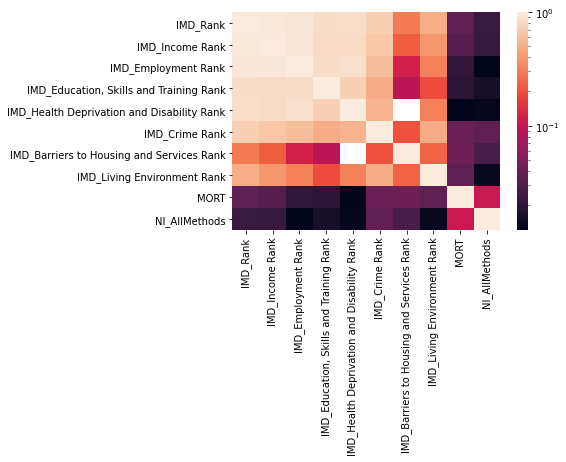

In [275]:

from matplotlib.colors import LogNorm

# Correlation heatmap of IMD components and Mortality
ColumnList = ['IMD_Rank',
             'IMD_Income Rank',
             'IMD_Employment Rank',
             'IMD_Education, Skills and Training Rank',
             'IMD_Health Deprivation and Disability Rank',
             'IMD_Crime Rank',
             'IMD_Barriers to Housing and Services Rank',
             'IMD_Living Environment Rank',
             'MORT',
             'NI_AllMethods']

Corr = df_7[ColumnList].corr('pearson')
sns.heatmap(Corr, norm=LogNorm())
Corr

In [284]:

df_8 = df_7

# # Dropping correlated features
ColumnDrops = ['dis_Spell_Patient died',
               'dis_Spell_Patient discharged on cl',
               'dis_dest_Spell_Not applicab',
               'cancercoded',
               'livercoded',
               'inhospital_MORT_ONS',
               'sex_Female',
               'HFRS_Band_None',
               'POD_NE',
               'dis_dest_Spell_Usual place ',
               'diabetescoded']
#                'OPCS_Z926', 'OPCS_U212', 'ICD10_I252',
#                'IMD_score', 'IMD_Rank', 'IMD_Employment Rank', 'IMD_Income Rank']

df_8 = df_8.drop(columns=ColumnDrops)

# Computing correlation matrix
CorrMat = df_8.corr().abs()

# Finding highly-correlated pairs
FeatureColumn = []
FeatureRow = []
Correlation = []
Threshold = 0.7
for (col,row), value in np.ndenumerate(CorrMat):
    if col>row:
        if value>Threshold:
            FeatureColumn.append(CorrMat.columns[col])
            FeatureRow.append(CorrMat.index[row])
            Correlation.append(value)

data_dict = {'Feature 1':FeatureColumn, 'Feature 2':FeatureRow, 'Correlation':Correlation}
df_Corr = pd.DataFrame(data=data_dict)
df_Corr.groupby(by=['Feature 1']).apply(display)


,Feature 1,Feature 2,Correlation
18,IMD_Crime Rank,IMD_Rank,0.709857


,Feature 1,Feature 2,Correlation
9,"IMD_Education, Skills and Training Rank",IMD_score,0.790754
10,"IMD_Education, Skills and Training Rank",IMD_Rank,0.830764
11,"IMD_Education, Skills and Training Rank",IMD_Income Rank,0.822233
12,"IMD_Education, Skills and Training Rank",IMD_Employment Rank,0.831750


,Feature 1,Feature 2,Correlation
6,IMD_Employment Rank,IMD_score,0.876539
7,IMD_Employment Rank,IMD_Rank,0.937746
8,IMD_Employment Rank,IMD_Income Rank,0.948694


,Feature 1,Feature 2,Correlation
13,IMD_Health Deprivation and Disability Rank,IMD_score,0.821265
14,IMD_Health Deprivation and Disability Rank,IMD_Rank,0.855771
15,IMD_Health Deprivation and Disability Rank,IMD_Income Rank,0.822578
16,IMD_Health Deprivation and Disability Rank,IMD_Employment Rank,0.879061
17,IMD_Health Deprivation and Disability Rank,"IMD_Education, Skills and Training Rank",0.727776


,Feature 1,Feature 2,Correlation
4,IMD_Income Rank,IMD_score,0.887226
5,IMD_Income Rank,IMD_Rank,0.960150


,Feature 1,Feature 2,Correlation
3,IMD_Rank,IMD_score,0.91993


,Feature 1,Feature 2,Correlation
0,NC_Method2_15,Diff_EPIstart_Admission,0.761744


,Feature 1,Feature 2,Correlation
1,NC_Method2_8,Diff_EPIstart_Admission,0.714942


,Feature 1,Feature 2,Correlation
2,NI_AllMethods,NC_Method1,0.767497


""


In [285]:

print('Size of remaining dataset:', df_8.shape)
print('including 5 target vectors')
df_8.head(2)

list(df_8.columns)


Size of remaining dataset: (374244, 109)
including 5 target vectors


['P_Spell_ID',
 'IMD_score',
 'procedure_group',
 'age_of_patient',
 'SpellCCdays',
 'MORT',
 'Spell_Los',
 'Admission_date',
 'Discharge_date',
 'Hopper_Index_1',
 'Hopper_Index_2',
 'Hopper_Index_3',
 'Hopper_Index_4',
 'Hopper_Index_5',
 'Hopper_Index_6',
 'Hopper_Index_7',
 'Total_Hopper_Domains',
 'Periferal_vasc',
 'heart_fail',
 'Acute_MI',
 'cerebral_vasc',
 'dementia',
 'Pulmonary_dis',
 'Connective',
 'Peptic_ulcer',
 'Liver_dis',
 'Diabetes_without',
 'Diabetes_with',
 'Hemi_para',
 'Renal_dis',
 'cancer',
 'metastatic',
 'Severe_liver',
 'HIV',
 'Charlson_Score',
 'Obesity',
 'Diff_EPIstart_Admission',
 'NC_Method1',
 'NC_Method2_15',
 'NC_Method2_8',
 'NC_Method4',
 'NI_AllMethods',
 'CountSameDay_Covid',
 'CountSameDay_NonCovid',
 'PropMaxPatientsWave_Covid',
 'PropMaxPatientsWave_NonCovid',
 'Severity_Pneumonia',
 'Severity_Kidney',
 'Severity_BloodClotting',
 'Severity_CardiologyCirculation',
 'Severity_Neurology',
 'Severity_DigestiveSystem',
 'Severity_Sepsis',
 'IMD_

In [286]:

df_9 = df_8

# Print Characteristics
Filter = (df_9['NC_Method1']==1) & (df_9['NI_AllMethods']==1)
print('NI indentified by M1 ONLY:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method2_15']==1) & (df_9['NI_AllMethods']==1)
print('NI indentified by M2_15 ONLY:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method2_8']==1) & (df_9['NI_AllMethods']==1)
print('NI indentified by M2_8 ONLY:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method4']==1) & (df_9['NI_AllMethods']==1)
print('NI indentified by M4 ONLY:', df_9[Filter]['NC_Method4'].sum())

print('------------------------')

# Print overlaps
Filter = (df_9['NC_Method1']==1) & (df_9['NC_Method2_15']==1)
print('NI indentified by BOTH M1 and M2.15:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method1']==1) & (df_9['NC_Method2_8']==1)
print('NI indentified by BOTH M1 and M2.8:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method1']==1) & (df_9['NC_Method4']==1)
print('NI indentified by BOTH M1 and M4:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method2_15']==1) & (df_9['NC_Method4']==1)
print('NI indentified by BOTH M2_15 and M4:', df_9[Filter]['NI_AllMethods'].sum())

Filter = (df_9['NC_Method2_8']==1) & (df_9['NC_Method4']==1)
print('NI indentified by BOTH M2_8 and M4:', df_9[Filter]['NI_AllMethods'].sum())

print('------------------------')

# Print Characteristics
print('NI indentified in TOTAL:', df_9['NI_AllMethods'].sum())
print('Out of:', df_9.shape[0])
print('Corresponding to:', 100*df_9['NI_AllMethods'].sum() / df_9['NI_AllMethods'].count(), ' %')



NI indentified by M1 ONLY: 18208
NI indentified by M2_15 ONLY: 7519
NI indentified by M2_8 ONLY: 15235
NI indentified by M4 ONLY: 160
------------------------
NI indentified by BOTH M1 and M2.15: 1937
NI indentified by BOTH M1 and M2.8: 3673
NI indentified by BOTH M1 and M4: 30
NI indentified by BOTH M2_15 and M4: 3
NI indentified by BOTH M2_8 and M4: 5
------------------------
NI indentified in TOTAL: 29896
Out of: 374244
Corresponding to: 7.98837122305234  %


## Saving File

In [287]:

df_9['Discharge_date'] = pd.to_datetime(df_9['Discharge_date'], format='%d/%m/%Y')

# Placing method features at end
ColumnMove = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4', 'NI_AllMethods']
NewFeatureList = list(df_9.columns)
for col in ColumnMove:
    NewFeatureList.remove(col)

NewFeatureList += ColumnMove
df_10 = df_9[NewFeatureList]

Save = True
if Save:
    df_9.to_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Final_AllIMD.csv')


# On-The-Side

### Add time spent in hospital before infection

In [ ]:

# ReadExcel = True

# if ReadExcel:
#     df_AllEpisodes = pd.read_excel(r'O:\DiRAC\FlavienHardy\2_NosocomialInfections\Data\0_Raw\MarchData\All episodes 07-06-21.xlsx')

    

In [ ]:

# # Add Time Spent Before Infection

# ColumnList = ['HESID', 'Admission_date', 'EPIstart', 'EPIend']
# df_Sub = df_AllEpisodes[ColumnList]
# Index_FirstInfection = df_Sub.groupby(by=['HESID', 'Admission_date'])['EPIstart'].idxmin().values
# df_Sub = df_Sub.loc[Index_FirstInfection]
# df_Sub['TimeBeforeNI'] = (df_Sub['EPIstart'] - df_Sub['Admission_date']).dt.days
# df_Sub.head()


In [ ]:

# # Merge with assembled dataframe
# ColumnList = ['HESID', 'Admission_date', 'EPIstart', 'TimeBeforeNI']
# df_Sub = df_Sub[ColumnList]

# df['Admission_date'] = pd.to_datetime(df['Admission_date'])
# df['EPIstart'] = pd.to_datetime(df['EPIstart'])

# ColumnMerge = ['HESID', 'Admission_date']
# df_Merge = pd.merge(df, df_Sub, how='left', left_on=ColumnMerge, right_on=ColumnMerge)
# df_Merge = df_Merge.drop(columns=['EPIstart_x']).rename(columns={'EPIstart_y':'EPIstart'})

# df_Merge.head(2)


In [ ]:
# On-The-Side

### Add time spent in hospital before infection


# ReadExcel = True

# if ReadExcel:
#     df_AllEpisodes = pd.read_excel(r'O:\DiRAC\FlavienHardy\2_NosocomialInfections\Data\0_Raw\MarchData\All episodes 07-06-21.xlsx')

    


# # Add Time Spent Before Infection

# ColumnList = ['HESID', 'Admission_date', 'EPIstart', 'EPIend']
# df_Sub = df_AllEpisodes[ColumnList]
# Index_FirstInfection = df_Sub.groupby(by=['HESID', 'Admission_date'])['EPIstart'].idxmin().values
# df_Sub = df_Sub.loc[Index_FirstInfection]
# df_Sub['TimeBeforeNI'] = (df_Sub['EPIstart'] - df_Sub['Admission_date']).dt.days
# df_Sub.head()



# # Merge with assembled dataframe
# ColumnList = ['HESID', 'Admission_date', 'EPIstart', 'TimeBeforeNI']
# df_Sub = df_Sub[ColumnList]

# df['Admission_date'] = pd.to_datetime(df['Admission_date'])
# df['EPIstart'] = pd.to_datetime(df['EPIstart'])

# ColumnMerge = ['HESID', 'Admission_date']
# df_Merge = pd.merge(df, df_Sub, how='left', left_on=ColumnMerge, right_on=ColumnMerge)
# df_Merge = df_Merge.drop(columns=['EPIstart_x']).rename(columns={'EPIstart_y':'EPIstart'})

# df_Merge.head(2)


In [ ]:

## Testing PCA

# ColumnList = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NI_AllMethods']
# X = df_8.drop(columns=ColumnList)

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# X_std = StandardScaler().fit_transform(X)
# N = 20
# pca = PCA(n_components=N)
# PrComponents = pca.fit_transform(X_std)


# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111)
# NI_idx = df_8[df_8['NI_AllMethods']==1].index
# CI_idx = df_8[df_8['NI_AllMethods']==0].index
# N1 = 2
# N2 = 4
# ax.scatter(PrComponents[CI_idx,N1], PrComponents[CI_idx,N2], alpha=0.5)
# ax.scatter(PrComponents[NI_idx,N1], PrComponents[NI_idx,N2], color='red', alpha=0.5)


In [ ]:

# # Diagnosis Group: most common codes in nosocomial infections
# def CommonCodes(df_ini, Filter_ini, N_ini):
#     df = df_ini
#     Filter = Filter_ini
#     N = N_ini
    
#     DiagnosisList = '~'.join(df[Filter]['diagnosis_group'].to_list())
#     DiagnosisList = DiagnosisList.split('~')

#     Count = Counter(DiagnosisList)

#     MostCommon_Codes = [code for code, codeCount in Count.most_common(N)]
#     Count_Codes = [codeCount for code, codeCount in Count.most_common(N)]
#     data_dict = {'Codes':MostCommon_Codes, 'Counts':Count_Codes}
#     df_Codes = pd.DataFrame(data=data_dict)

#     ElementToRemove = ['-1', 'U071', 'U072', '-1U071', 'Y95X']
#     for elem in ElementToRemove:
#         Index = df_Codes[df_Codes['Codes']==elem].index
#         df_Codes = df_Codes.drop(Index)

#     df_Codes['Prop'] = 100*df_Codes['Counts']/df[Filter].shape[0]
    
#     return df_Codes
    
# Filter_0 = df['NI_AllMethods']==0
# Filter_1 = df['NI_AllMethods']==1

# N = 50
# df_Common_0 = CommonCodes(df, Filter_0, N)
# df_Common_1 = CommonCodes(df, Filter_1, N)

# CodesCorr_NI = []
# Prop0_list = []
# Prop1_list = []

# for code in list(df_Common_1['Codes'].values):
#     Filter1 = df_Common_1['Codes']==code
#     Prop1 = df_Common_1[Filter1]['Prop'].values[0]
    
#     if code in list(df_Common_0['Codes'].values):
#         Filter0 = df_Common_0['Codes']==code
#         Prop0 = df_Common_0[Filter0]['Prop'].values[0]
        
#         if Prop1 >= 1.2*Prop0:
#             CodesCorr_NI.append(code)
#             Prop1_list.append(Prop1)
#             Prop0_list.append(Prop0)
#     else:
#         CodesCorr_NI.append(code)
#         Prop1_list.append(Prop1)
#         Prop0_list.append(0)

# data_dict = {'Code':CodesCorr_NI, 'Prop1':Prop1_list, 'Prop0':Prop0_list}
# df_CodeProp = pd.DataFrame(data=data_dict)

# df_OnlyNI = df_CodeProp[df_CodeProp['Prop0']==0]
# df_MoreCommonNI = df_CodeProp[df_CodeProp['Prop0']>0]

# NI_MoreCommon = df_MoreCommonNI['Code'][df_MoreCommonNI['Prop1']>14]
# NI_Only = df_OnlyNI['Code'][df_OnlyNI['Prop1']>7]
# # df_OnlyNI[df_OnlyNI['Prop1']>7]

# CodesInclude = list(NI_MoreCommon) + list(NI_Only)
# print('Codes that seem correlated with NI:')
# print(CodesInclude)
# print('Adding ', len(CodesInclude), ' new features...')


## Adding Method 4

In [305]:

# # Importing File
# ReadExcel = False
# if ReadExcel:
#     df_M4 = pd.read_excel(r'O:\GIRFT DiRAC\FlavienHardy\0_Datasets_Ini\06.22\Z208 21-06-21.xlsx')
    

In [433]:

# df_9 = df_8

# # Extracting columns of interest in df_M4
# df_M4['NC_Method4'] = 1
# ColumnsList = ['HESID', 'Admission_date', 'NC_Method4']
# df_M4_Sub = df_M4[ColumnsList]

# # Merging with current dataset
# df_9.loc[:,'Admission_date'] = df_Assembled['Admission_date']
# df_9.loc[:,'HESID'] = df_Assembled['HESID']
# df_9.loc[:,'P_Spell_ID'] = df_Assembled['P_Spell_ID']

# ColumnList = ['HESID', 'Admission_date']
# df_M4_Sub.loc[:,'Admission_date'] = pd.to_datetime(df_M4_Sub['Admission_date'])
# df_9.loc[:,'Admission_date'] = pd.to_datetime(df_9['Admission_date'])

# df_9 = pd.merge(df_9, df_M4_Sub, how='left', left_on=ColumnList, right_on=ColumnList)

# # Filling NaNs for infections in df_9 but NOT in df_M4 
# df_9['NC_Method4'] = df_9['NC_Method4'].fillna(0)
# df_9['NC_Method4'] = df_9['NC_Method4'].astype('int32')

# # Dropping 
# ColumnList = ['Admission_date', 'HESID', 'P_Spell_ID']
# df_9 = df_9.drop(columns=ColumnList)

# # Correcting overall NI-identification vector
# Filter = (df_9['NI_AllMethods'] + df_9['NC_Method4']>0)
# df_9['NI_AllMethods'] = np.where(Filter, 1, 0)

# print('Size of current dataset:', df_9.shape)
# print('including 5 target vectors')

# PresenceNaN = df_9.isnull().any().any()
# if not(PresenceNaN):
#     print('No missing value.')


C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\flavien.hardy\OneDrive - NHS Improvement\Desktop\FH_Local\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Size of current dataset: (366859, 125)
including 5 target vectors
No missing value.


## Modelling strain on trust on day of admission

In [7]:

# df2 = df

# # Create dataframe with Provider name | Admission date | Number of admissions on that date
# def NbAdmissionSameDay(df):
#     ColumnList = ['Provider_Name', 'Admission_date','HESID']
#     df_ProvCountDay = df[ColumnList].groupby(by=['Provider_Name', 'Admission_date'])['HESID'].count().to_frame(name='CountSameDay').reset_index()
#     df_ProvCountDay.head()

#     ColumnList = ['Provider_Name', 'Admission_date']
#     df = pd.merge(df, df_ProvCountDay, how='left', on=ColumnList)
#     return df

# df2 = NbAdmissionSameDay(df)
# df2.head()


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,HIV,Charlson_Score,Obesity,Diff_EPIstart_Admission,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,CountSameDay
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,0,1,0,45,0,1,1,0,1,35
1,2169012,9.970,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0,1,1,0,0,0,0,0,0,1
2,2201273,2.314,10.0,5.0,British,White,7.007760e+11,W461~Z943~U212~Y982~Z924~Z401~U051~Y981~-1~-1~...,Male,90,...,0,4,0,0,0,0,0,0,0,22
3,2947750,11.831,7.0,4.0,British,White,7.007770e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,39,...,0,0,0,0,0,0,0,0,0,2
4,3445944,30.350,3.0,2.0,British,White,7.007880e+11,U212~Y981~Z411~Z941~Z413~Z941~Z421~X403~X404~X...,Male,52,...,0,4,0,11,1,0,1,0,1,29


In [139]:

# df3 = df2.copy()

# def WaveStrain(df):
#     # Create feature for specific wave according to admission date
#     FirstWave_end = pd.to_datetime('31/07/2020', format='%d/%m/%Y').strftime('%d/%m/%Y')
#     df['Admission_date'] = pd.to_datetime(df['Admission_date'], format='%d/%m/%Y').dt.strftime('%d/%m/%Y')
#     Filter = df['Admission_date']<=FirstWave_end
#     df['Wave'] = np.where(Filter, 1, 2)


#     # Find maximum number of admissions during specific wave
#     ColumnList = ['Provider_Name', 'Wave', 'Admission_date', 'HESID']
#     df_WaveMaxPatients = df[ColumnList].groupby(by=['Provider_Name', 'Wave', 'Admission_date'])['HESID'].count().to_frame(name='CountWave').reset_index()
#     df_WaveMaxPatients = df_WaveMaxPatients.groupby(by=['Provider_Name', 'Wave'])['CountWave'].max().to_frame(name='MaxWave').reset_index()

#     ColumnList = ['Provider_Name', 'Wave']
#     df4 = pd.merge(df, df_WaveMaxPatients, how='left', on=ColumnList)

#     # Add proportion to maximum admissions during specific wave
#     df4['PropMaxPatientsWave'] = 100*df4['CountSameDay']/df4['MaxWave']

#     # Drop intermediary columns
#     ColumnDrops = ['Wave', 'MaxWave']
#     df4 = df4.drop(columns=ColumnDrops)
    
#     return df4

# df4 = WaveStrain(df3)
# df4.head()


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,Charlson_Score,Obesity,Diff_EPIstart_Admission,NC_Method1,NC_Method2_15,NC_Method2_8,NC_Method4,NI_AllMethods,CountSameDay,PropMaxPatientsWave
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,1,0,45,0,1,1,0,1,35,56.451613
1,2169012,9.970,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,1,1,0,0,0,0,0,0,1,1.960784
2,2201273,2.314,10.0,5.0,British,White,7.007760e+11,W461~Z943~U212~Y982~Z924~Z401~U051~Y981~-1~-1~...,Male,90,...,4,0,0,0,0,0,0,0,22,100.000000
3,2947750,11.831,7.0,4.0,British,White,7.007770e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,39,...,0,0,0,0,0,0,0,0,2,5.882353
4,3445944,30.350,3.0,2.0,British,White,7.007880e+11,U212~Y981~Z411~Z941~Z413~Z941~Z421~X403~X404~X...,Male,52,...,4,0,11,1,0,1,0,1,29,40.277778


## Most common ICD-10 Codes for NI

In [251]:

# # Diagnosis Group: most common codes in nosocomial infections

# def CodesCounts(df, Filter):
#     # Splitting ICD-10 chains
#     DiagnosisList = '-'.join(df[Filter]['ICD10_All'].to_list())
#     DiagnosisList = DiagnosisList.split('-')

#     # Creating dataframe
#     Count = pd.Series(Counter(DiagnosisList))
#     df_Codes = pd.DataFrame({'Codes':Count.index, 'Count':Count.values}).sort_values(by=['Count'], ascending=False)

#     # Removing unwanted elements
#     ElementToRemove = ['-1', 'U071', 'U072', 'Y95X']
#     for elem in ElementToRemove:
#         Index = df_Codes[df_Codes['Codes']==elem].index
#         df_Codes = df_Codes.drop(Index)
    
#     df_Codes['Count'] = 100 * df_Codes['Count'] / df[Filter].shape[0]

#     return df_Codes

# Filter_1 = df5['NI_AllMethods']==1
# Filter_0 = df5['NI_AllMethods']==0
# df_Codes_1 = CodesCounts(df5, Filter_1)
# df_Codes_0 = CodesCounts(df5, Filter_0)

# df_Cont = pd.merge(df_Codes_0, df_Codes_1, how='outer', on='Codes').fillna(0).rename(columns={'Count_x':'Count_0', 'Count_y':'Count_1'})
# df_Cont['Difference'] = df_Cont['Count_1']-df_Cont['Count_0']
# df_Cont['Risk ratio'] = df_Cont['Count_1']/df_Cont['Count_0']
# df_Cont = df_Cont.sort_values(by=['Count_1'], ascending=False)

# # Filter codes that are common enough with NI, and with high risk ratio
# Filter = (df_Cont['Count_1']>9) & (abs(df_Cont['Risk ratio'])>1.2)
# df_Common = df_Cont[ Filter ]

# CodesInclude = df_Common['Codes'].values
# print('Codes that seem correlated with NI:')
# print(CodesInclude)
# # print('Adding ', len(CodesInclude), ' new features...')

# df_Common[0:5]

Codes that seem correlated with NI:
['N179' 'Z501' 'I489' 'R296' 'Z515' 'N390' 'Z507' 'J90X' 'Z921' 'K590'
 'I500' 'J440' 'I259' 'R54X' 'E86X' 'Z290' 'R33X' 'F059' 'J181' 'D649'
 'J189' 'N183' 'E876' 'N189' 'A419' 'I252' 'R268']


,Codes,Count_0,Count_1,Difference,Risk ratio
4,N179,19.814838,33.201766,13.386928,1.675601
5,Z501,19.622301,27.221033,7.598732,1.387250
6,I489,16.109575,26.361386,10.251811,1.636380
12,R296,10.580866,21.149987,10.569121,1.998890
15,Z515,9.803455,19.119615,9.316160,1.950294


In [260]:

# Inclusion as new feature
# for code in CodesInclude:
#     Filter = df5['ICD10_All'].str.contains(code)
#     df5['ICD10_'+code] = np.where(Filter, 1, 0)

# print('New size:', df5.shape)
# df5.head(2)


New size: (374244, 110)


,P_Spell_ID,IMD_score,IMD_decile,IMD_quintile,Ethnicity_updated,ethnicity_updated_cat,Epikey,procedure_group,sex,age_of_patient,...,ICD10_F059,ICD10_J181,ICD10_D649,ICD10_J189,ICD10_N183,ICD10_E876,ICD10_N189,ICD10_A419,ICD10_I252,ICD10_R268
0,1487000,NaN,NaN,NaN,British,White,7.007780e+11,S353~Z504~Z943~Y588~Z504~Z943~-1~-1~-1~-1~-1~-...,Male,38,...,0,0,0,0,0,0,0,0,0,0
1,2169012,9.97,8.0,4.0,British,White,7.007830e+11,-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-1~-...,Female,75,...,0,0,0,0,0,0,0,0,0,1
